<a href="https://colab.research.google.com/github/EricRibeiroAlves/Interacao-Humano-Robo/blob/main/Codigo/%5BAP_T%5D_Eric_Markovs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Legenda**:
- $dt$: Passo de tempo (incremento de tempo entre as amostras).
- $t$: Tempo total (ou carimbo de tempo) da amostra.
- $\frac{d\tau_{r}}{dt}$ [R_d_T]: Derivada do torque do robô (variação do torque com o tempo).
- $\tau_{r}$ [R_T]: Torque do robô.
- $S_Fx$ [R_Fx]: Sensor de torque Tx.
- $\omega_{l}$ [R_w_l]: Velocidade da coroa.
- $\theta_{l}$ [R_t_l]: Ângulo da coroa.
- $\omega_{h}$ [R_w_p]: Velocidade da pessoa.
- $\theta_{h}$ [R_t_p]: Ângulo da pessoa.
- $∫e(Interacao).dt$ [R_i_T_e]: Integral do erro de torque.
- $U(x)$ [R_u]: Sinal de controle.
- $\tau^{d}_{r}$ [R_T_d]: Torque desejado do robô.
- $\theta_{m}$ [R_t_m]: Ângulo do motor.
- $\frac{d\omega_{l}}{dt}$ [R_d_w_l]: Derivada da velocidade da coroa (variação da velocidade da coroa com o tempo).
- $phase$: Fase do movimento ou do ciclo (possivelmente relacionada à fase da marcha).
- $\theta_{m, L}$ [L_t_m]: Ângulo do motor na perna esquerda.
- $\theta_{l, L}$ [L_t_l]: Ângulo da coroa na perna esquerda.
- $L_u$: Sinal de controle aplicado ao lado esquerdo.
- $\tau_{r, L}$ [L_T_r]: Torque real no lado esquerdo.
- $\tau^{d}_{r, L}$ [L_T_d]: Torque desejado no lado esquerdo.

### Variáveis adicionais (não presentes no dataset mas relevantes no código):
- $\tau_{i}$ [R_T_i]: Torque de interação.

# Bibliotecas

In [1]:
# Trato dos dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import sheets

# Libs p/ Modelo Deep LTSM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1º Passo: Montar o Drive e carregar o dataset


In [2]:
head_markov = ['dt', 't', 'R_d_T', 'R_T', 'R_Fx',
               'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p',
               'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m',
               'R_d_w_l', 'phase', 'L_t_m', 'L_t_l',
               'L_u', 'L_T_r', 'L_T_d']

drive.mount('/content/drive')

t1_markov = "drive/MyDrive/Markov/T1_1/last_data_MarkovMao 1.dat"
t2_markov = "drive/MyDrive/Markov/T2/last_data_MarkovMao 1.dat"
t3_markov = "drive/MyDrive/Markov/T3/last_data_MarkovMao 1.dat"
t4_markov = "drive/MyDrive/Markov/T4/last_data_MarkovMao 1.dat"
t5_markov = "drive/MyDrive/Markov/T5_1/last_data_MarkovMao 1.dat"
t6_markov = "drive/MyDrive/Markov/T6/last_data_MarkovMao 1.dat"
t7_markov = "drive/MyDrive/Markov/T7/last_data_MarkovMao 1.dat"
t8_markov = "drive/MyDrive/Markov/T8/last_data_MarkovMao 1.dat"

pd.set_option('display.float_format', lambda x: '%.10f' % x)

# Precido de: ['R_w_l'] F, ['R_t_l'] G, ['R_w_p'] H, ['R_t_p'] I

markov_t1 = pd.read_table(t1_markov, header=None, names=head_markov, index_col=False) # Sem: R_T_d, R_w_l com falhas
markov_t2 = pd.read_table(t2_markov, header=None, names=head_markov, index_col=False) # Sem: ; *R_w_l com falhas (esse ta ótimo!) ♥
markov_t3 = pd.read_table(t3_markov, header=None, names=head_markov, index_col=False) # Sem: R_w_l, R_T_d
markov_t4 = pd.read_table(t4_markov, header=None, names=head_markov, index_col=False) # Sem: R_w_l, R_T_d
markov_t5 = pd.read_table(t5_markov, header=None, names=head_markov, index_col=False) # Sem: R_T_d; R_w_l com falhas
markov_t6 = pd.read_table(t6_markov, header=None, names=head_markov, index_col=False) # Sem: ; *R_w_l com falhas (esse ta ótimo!) ♥
markov_t7 = pd.read_table(t7_markov, header=None, names=head_markov, index_col=False) # Sem: R_w_l, R_T_d, L_T_d                    *Sendo Utilizado nos Modelos (!!)
markov_t8 = pd.read_table(t8_markov, header=None, names=head_markov, index_col=False) # Sem: R_w_l, R_T_d


Mounted at /content/drive


In [ ]:
drive.flush_and_unmount()

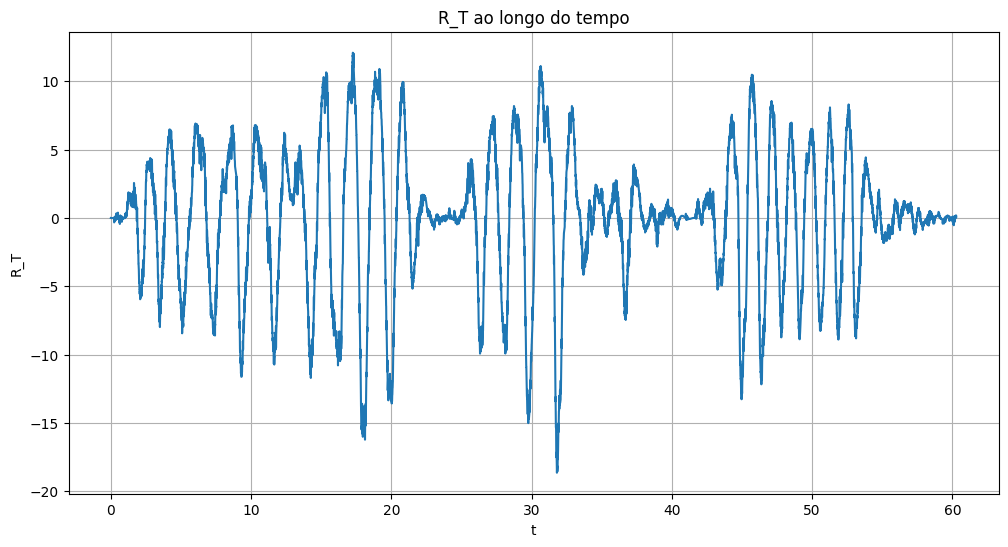

In [ ]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t1['t'].iloc[:], markov_t1['R_T'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

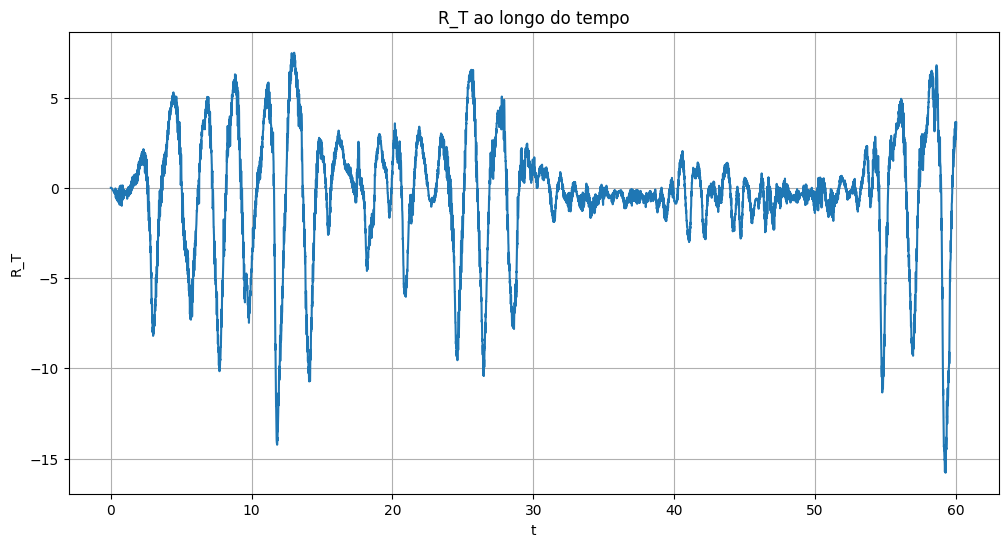

In [ ]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t2['t'].iloc[:], markov_t2['R_T'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

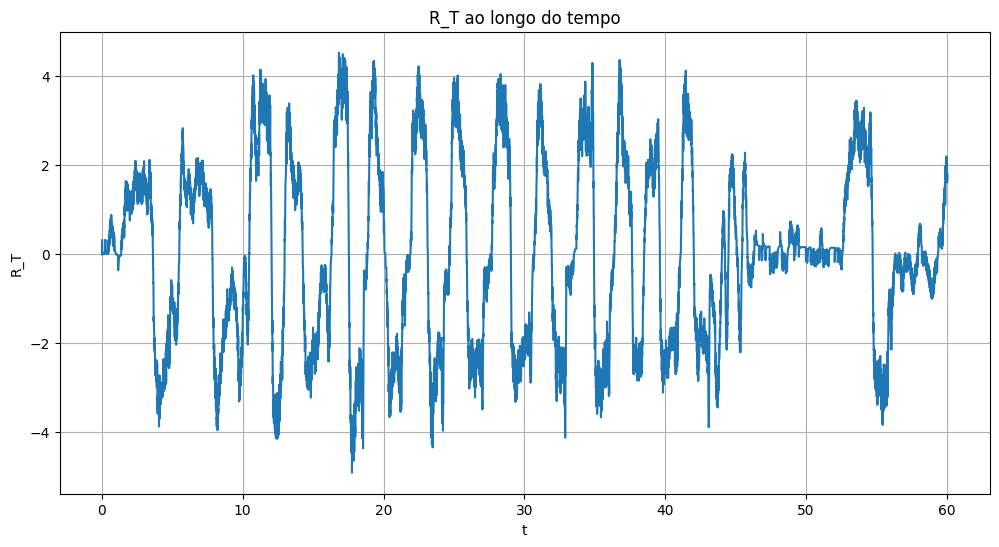

In [ ]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t3['t'].iloc[:], markov_t3['R_T'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

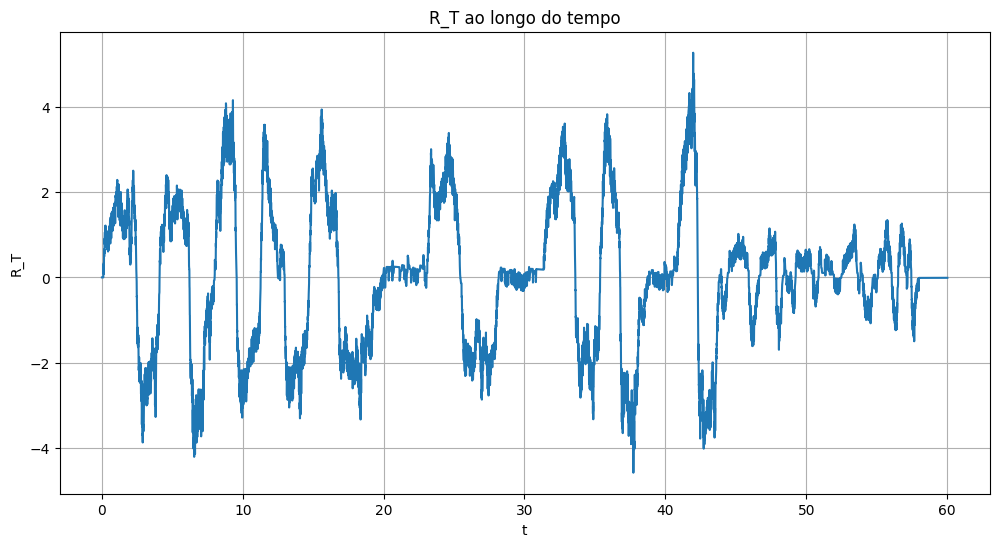

In [ ]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t4['t'].iloc[:], markov_t4['R_T'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

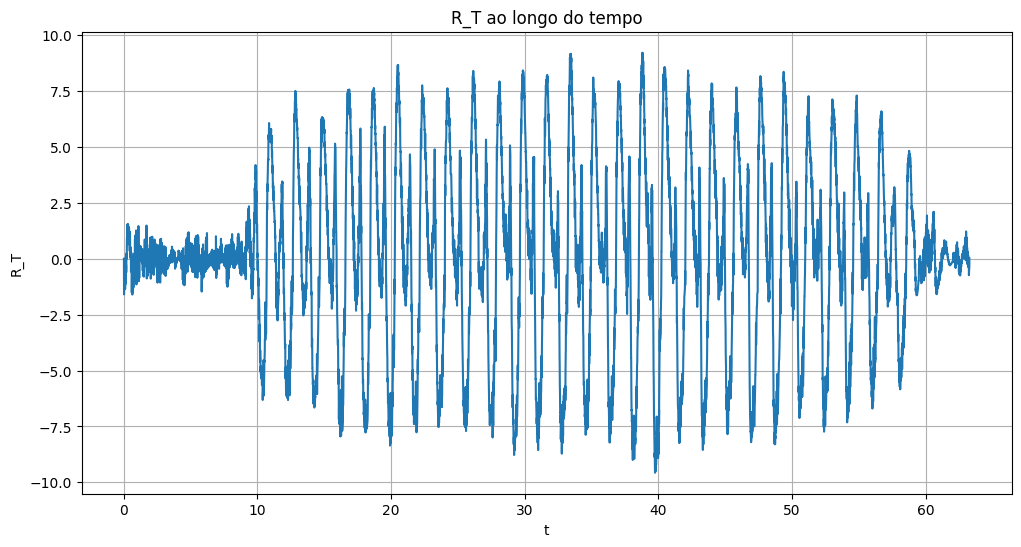

In [ ]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t5['t'].iloc[:], markov_t5['R_T'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

## Markov 6

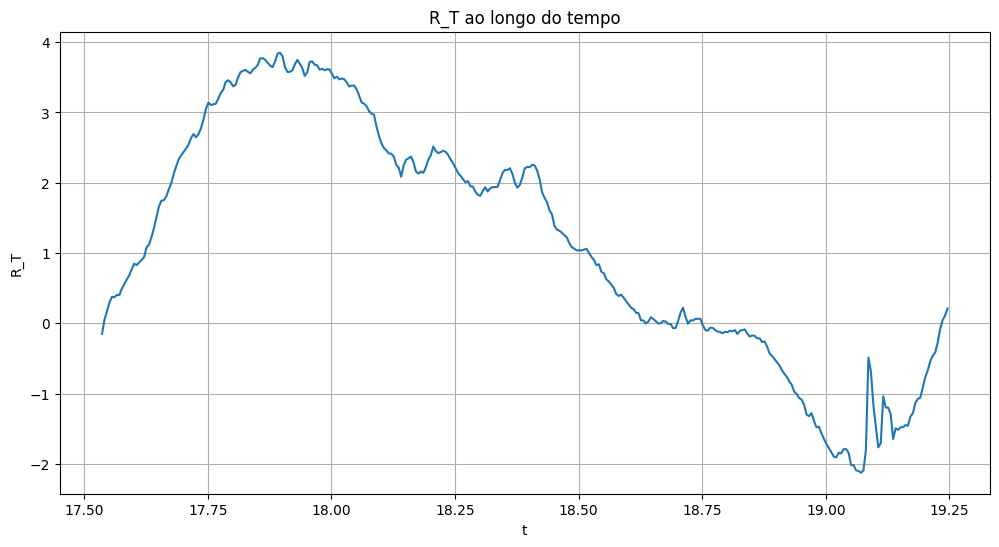

,dt,t,R_d_T,R_T,R_Fx,R_w_l,R_t_l,R_w_p,R_t_p,R_i_T_e,R_u,R_T_d,R_t_m,R_d_w_l,phase,L_t_m,L_t_l,L_u,L_T_r,L_T_d
0,0.0000641000,0.0000000000,0.0000000000,0.0000000000,-0.6070281863,0.0000000000,0.0000000000,0.0628370643,-0.2879152000,0.0000000000,7.3415497690,0.0000000000,0.0000000000,0.0000000000,5.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1,0.0000353000,0.0050000000,0.0000000000,0.0000000000,-0.0230400376,0.0000000000,0.0000000000,0.0000000000,0.0000000000,-0.0015175705,-2.5981481618,-0.3035140932,0.0000000000,0.0000000000,5.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2,0.0000181000,0.0100000000,0.0000000000,0.0000000000,-0.0151488241,0.0000000000,0.0000000000,0.0000000000,0.0000000000,-0.0015751706,-2.7186763578,-0.0115200188,0.0000000000,0.0000000000,5.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
3,0.0000301000,0.0150000000,0.0000000000,0.0000000000,-0.0380640626,0.0000000000,0.0000000000,0.0000000000,0.0000000000,-0.0016130426,-2.7276643654,-0.0075744120,0.0000000000,0.0000000000,5.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
4,0.0000222000,0.0200000000,0.0000000000,0.0000000000,0.0151968244,0.0000000000,0.0000000000,0.0000000000,0.0000000000,-0.0017082028,-3.0273468532,-0.0190320313,0.0000000000,0.0000000000,5.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11994,0.0000186000,60.0080000000,-18.9313678741,-1.6868062019,-1.6406090260,0.3067961633,-0.2638446987,-0.5295984745,-0.2036027759,0.0366942286,626.6346201208,-0.8091924787,-42.0095978570,-0.0000000000,1.0000000000,19.8374395489,0.1288543862,-12.4313845805,1.0185632432,0.0000000000
11995,0.0000340000,60.0130000000,-18.3995895386,-1.8708020449,-1.6754426956,0.3067961633,-0.2607767284,-0.5295984745,-0.2036027759,0.0419467166,666.1395513821,-0.8203045130,-41.8147822970,-0.0000000000,1.0000000000,19.8374395489,0.1288543862,-12.4517558449,1.0185632432,0.0000000000
11996,0.0000363000,60.0180000000,-3.2970361710,-1.7197765112,-1.6114442348,0.3067961633,-0.2607767284,-0.5295984745,-0.2036027759,0.0463569909,479.0893776096,-0.8377213478,-41.5969570251,-0.0000000000,1.0000000000,19.8374395489,0.1288543862,-12.4721271093,1.0185632432,0.0000000000
11997,0.0000426000,60.0230000000,7.4449200630,-1.7963528633,-1.5913177729,0.3067961633,-0.2577087581,-0.5295984745,-0.2036027759,0.0513101481,386.0365513718,-0.8057221174,-41.2472094055,-0.0000000000,1.0000000000,19.8374395489,0.1288543862,-12.4924983737,1.0185632432,0.0000000000


In [27]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t6['t'].iloc[3505:3848], markov_t6['R_T_d'].iloc[3505:3848])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()
markov_t6

In [28]:
# Primeiro, vamos explorar a estrutura dos dados
print("=== ESTRUTURA DOS DATASETS ===")
for i, df in enumerate([markov_t1, markov_t2, markov_t3, markov_t4, markov_t5, markov_t6, markov_t7, markov_t8], 1):
    print(f"T{i}: {df.shape} - Colunas: {list(df.columns)}")
    print(f"   Amostras: {len(df)} - Tempo total: {df['t'].iloc[-1] if len(df) > 0 else 0:.2f}s")
    print(f"   Fases únicas: {df['phase'].unique() if 'phase' in df.columns else 'N/A'}")
    print()

# Vamos focar no T6 que você destacou como bom
print("=== ANÁLISE DETALHADA T6 ===")
print(markov_t6.info())
print("\nEstatísticas descritivas:")
print(markov_t6.describe())

# Verificar valores ausentes
print("\nValores ausentes por coluna:")
print(markov_t6.isnull().sum())

# Visualizar as fases da marcha
if 'phase' in markov_t6.columns:
    print("\nDistribuição das fases:")
    print(markov_t6['phase'].value_counts().sort_index())

=== ESTRUTURA DOS DATASETS ===
T1: (11999, 20) - Colunas: ['dt', 't', 'R_d_T', 'R_T', 'R_Fx', 'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p', 'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m', 'R_d_w_l', 'phase', 'L_t_m', 'L_t_l', 'L_u', 'L_T_r', 'L_T_d']
   Amostras: 11999 - Tempo total: 60.28s
   Fases únicas: [5. 1. 3. 2. 4.]

T2: (11999, 20) - Colunas: ['dt', 't', 'R_d_T', 'R_T', 'R_Fx', 'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p', 'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m', 'R_d_w_l', 'phase', 'L_t_m', 'L_t_l', 'L_u', 'L_T_r', 'L_T_d']
   Amostras: 11999 - Tempo total: 60.04s
   Fases únicas: [5. 1. 4. 3. 2.]

T3: (11999, 20) - Colunas: ['dt', 't', 'R_d_T', 'R_T', 'R_Fx', 'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p', 'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m', 'R_d_w_l', 'phase', 'L_t_m', 'L_t_l', 'L_u', 'L_T_r', 'L_T_d']
   Amostras: 11999 - Tempo total: 60.03s
   Fases únicas: [5. 1. 2. 3. 4.]

T4: (11999, 20) - Colunas: ['dt', 't', 'R_d_T', 'R_T', 'R_Fx', 'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p', 'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m', 'R_d_w_l', '

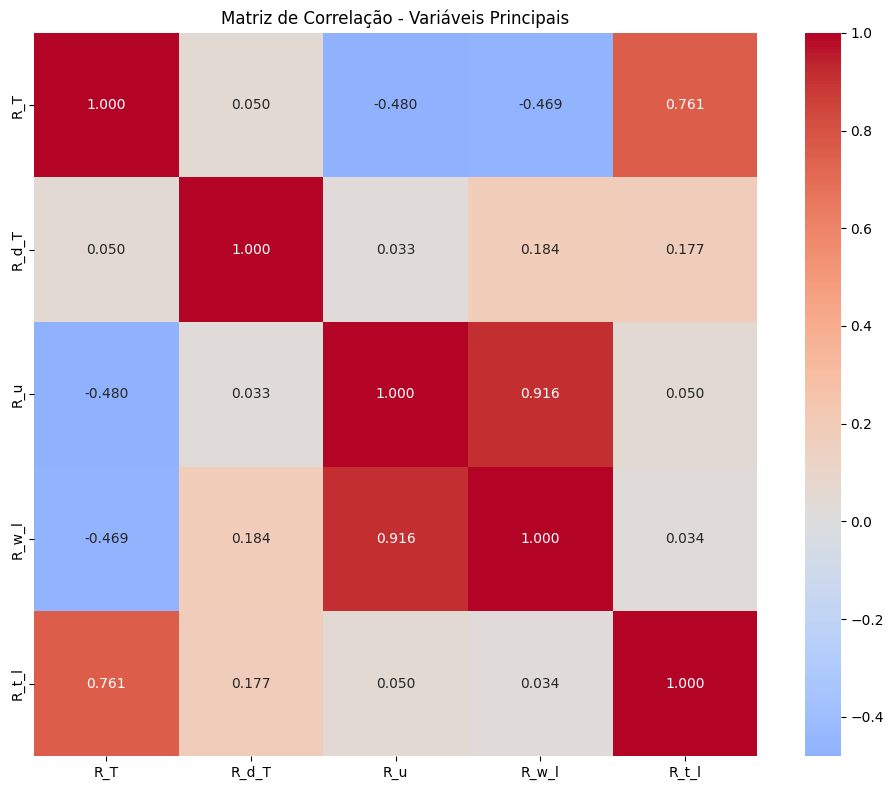

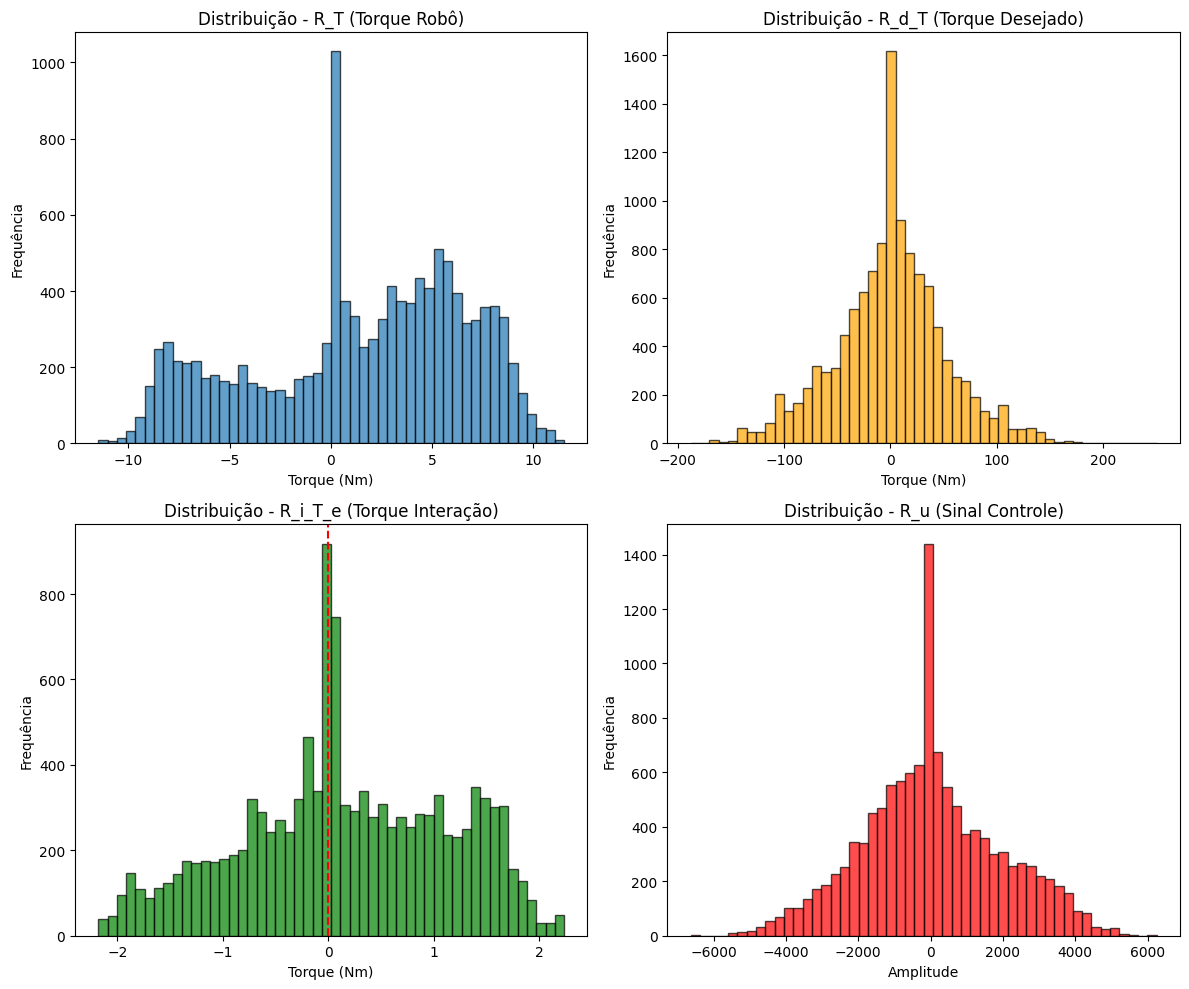

In [29]:
# Análise de correlação entre variáveis importantes
vars_analysis = ['R_T', 'R_d_T', 'R_u', 'R_w_l', 'R_t_l']
if all(col in markov_t6.columns for col in vars_analysis):
    correlation_matrix = markov_t6[vars_analysis].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.3f')
    plt.title('Matriz de Correlação - Variáveis Principais')
    plt.tight_layout()
    plt.show()

# Distribuição dos torques
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

if 'R_T' in markov_t6.columns:
    axes[0,0].hist(markov_t6['R_T'], bins=50, alpha=0.7, edgecolor='black')
    axes[0,0].set_title('Distribuição - R_T (Torque Robô)')
    axes[0,0].set_xlabel('Torque (Nm)')
    axes[0,0].set_ylabel('Frequência')

if 'R_d_T' in markov_t6.columns:
    axes[0,1].hist(markov_t6['R_d_T'], bins=50, alpha=0.7, edgecolor='black', color='orange')
    axes[0,1].set_title('Distribuição - R_d_T (Torque Desejado)')
    axes[0,1].set_xlabel('Torque (Nm)')
    axes[0,1].set_ylabel('Frequência')

if 'R_i_T_e' in markov_t6.columns:
    axes[1,0].hist(markov_t6['R_i_T_e'], bins=50, alpha=0.7, edgecolor='black', color='green')
    axes[1,0].set_title('Distribuição - R_i_T_e (Torque Interação)')
    axes[1,0].set_xlabel('Torque (Nm)')
    axes[1,0].set_ylabel('Frequência')
    axes[1,0].axvline(x=0, color='red', linestyle='--', label='Zero')

if 'R_u' in markov_t6.columns:
    axes[1,1].hist(markov_t6['R_u'], bins=50, alpha=0.7, edgecolor='black', color='red')
    axes[1,1].set_title('Distribuição - R_u (Sinal Controle)')
    axes[1,1].set_xlabel('Amplitude')
    axes[1,1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()


=== ESTATÍSTICAS DO ERRO DE TORQUE ===
Erro médio: -1.4737 Nm
Desvio padrão do erro: 52.0560 Nm
Erro máximo: 242.4534 Nm
Erro mínimo: -184.6989 Nm
RMSE: 52.0747 Nm

Correlação Torque Interação vs Erro: 0.3718


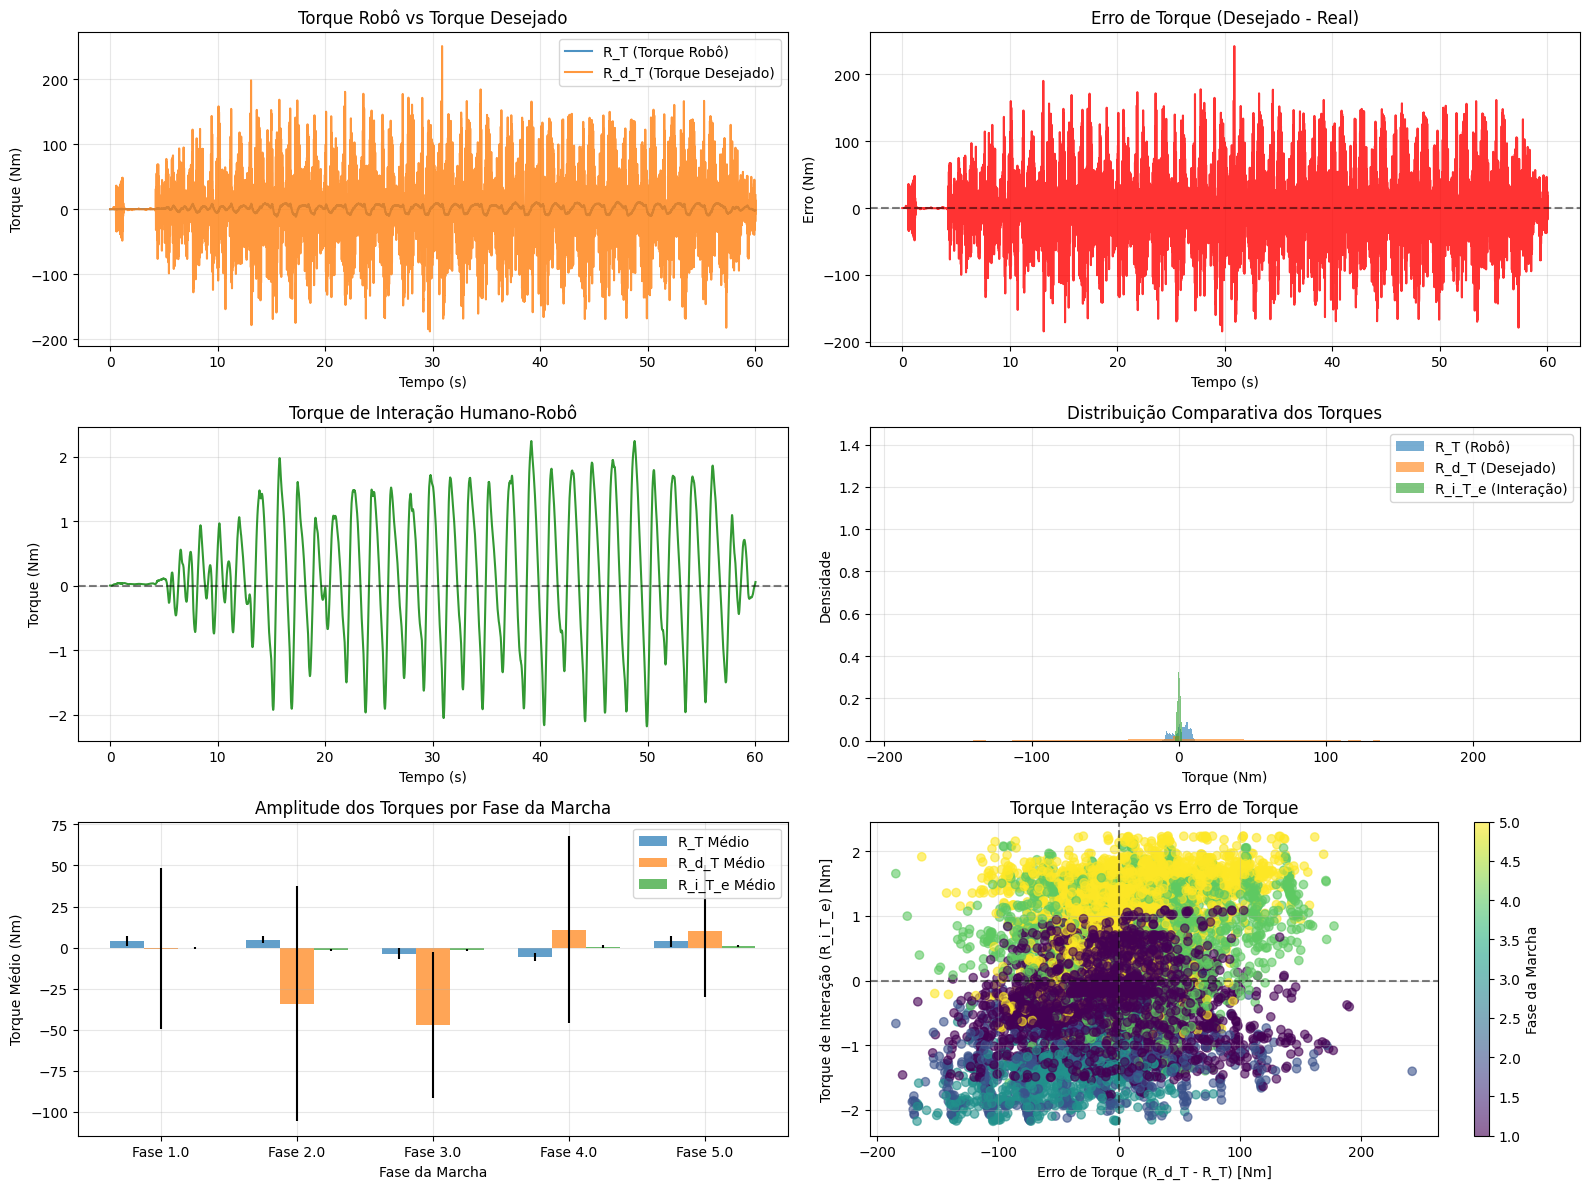


=== ESTATÍSTICAS DETALHADAS POR FASE ===
         phase      R_T_mean      R_T_std     R_d_T_mean     R_d_T_std  \
0 1.0000000000  4.0700000000 3.2320000000  -0.6218000000 49.1584000000   
1 2.0000000000  4.7171000000 2.0565000000 -34.2225000000 71.4957000000   
2 3.0000000000 -3.7930000000 3.4047000000 -46.9815000000 44.3645000000   
3 4.0000000000 -5.9657000000 2.4396000000  10.8711000000 57.0499000000   
4 5.0000000000  3.8731000000 3.3250000000  10.1240000000 40.1199000000   

   R_i_T_e_mean  R_i_T_e_std  samples  
0 -0.2724000000 0.5689000000     3170  
1 -1.3195000000 0.5022000000      761  
2 -1.2609000000 0.5329000000      976  
3  0.5089000000 0.8240000000     2328  
4  0.7851000000 0.6765000000     4764  


In [30]:
# Configuração para análise de torque
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# 1. Comparação direta: Torque Robô vs Torque Desejado
axes[0,0].plot(markov_t6['t'], markov_t6['R_T'], label='R_T (Torque Robô)', alpha=0.8, linewidth=1.5)
axes[0,0].plot(markov_t6['t'], markov_t6['R_d_T'], label='R_d_T (Torque Desejado)', alpha=0.8, linewidth=1.5)
axes[0,0].set_title('Torque Robô vs Torque Desejado')
axes[0,0].set_xlabel('Tempo (s)')
axes[0,0].set_ylabel('Torque (Nm)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Erro de torque (Desejado - Real)
if all(col in markov_t6.columns for col in ['R_T', 'R_d_T']):
    torque_error = markov_t6['R_d_T'] - markov_t6['R_T']
    axes[0,1].plot(markov_t6['t'], torque_error, label='Erro de Torque', color='red', alpha=0.8)
    axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[0,1].set_title('Erro de Torque (Desejado - Real)')
    axes[0,1].set_xlabel('Tempo (s)')
    axes[0,1].set_ylabel('Erro (Nm)')
    axes[0,1].grid(True, alpha=0.3)

    # Estatísticas do erro
    print(f"\n=== ESTATÍSTICAS DO ERRO DE TORQUE ===")
    print(f"Erro médio: {torque_error.mean():.4f} Nm")
    print(f"Desvio padrão do erro: {torque_error.std():.4f} Nm")
    print(f"Erro máximo: {torque_error.max():.4f} Nm")
    print(f"Erro mínimo: {torque_error.min():.4f} Nm")
    print(f"RMSE: {np.sqrt((torque_error**2).mean()):.4f} Nm")

# 3. Torque de Interação vs Erro de Torque
if all(col in markov_t6.columns for col in ['R_i_T_e', 'R_T', 'R_d_T']):
    axes[1,0].plot(markov_t6['t'], markov_t6['R_i_T_e'], label='Torque Interação (R_i_T_e)', color='green', alpha=0.8)
    axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1,0].set_title('Torque de Interação Humano-Robô')
    axes[1,0].set_xlabel('Tempo (s)')
    axes[1,0].set_ylabel('Torque (Nm)')
    axes[1,0].grid(True, alpha=0.3)

    # Correlação entre torque de interação e erro
    correlation = np.corrcoef(markov_t6['R_i_T_e'], torque_error)[0,1]
    print(f"\nCorrelação Torque Interação vs Erro: {correlation:.4f}")

# 4. Histograma comparativo dos torques
if all(col in markov_t6.columns for col in ['R_T', 'R_d_T', 'R_i_T_e']):
    axes[1,1].hist(markov_t6['R_T'], bins=100, alpha=0.6, label='R_T (Robô)', density=True)
    axes[1,1].hist(markov_t6['R_d_T'], bins=100, alpha=0.6, label='R_d_T (Desejado)', density=True)
    axes[1,1].hist(markov_t6['R_i_T_e'], bins=100, alpha=0.6, label='R_i_T_e (Interação)', density=True)
    axes[1,1].set_title('Distribuição Comparativa dos Torques')
    axes[1,1].set_xlabel('Torque (Nm)')
    axes[1,1].set_ylabel('Densidade')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

# 5. Análise de amplitudes por fase da marcha
if 'phase' in markov_t6.columns and all(col in markov_t6.columns for col in ['R_T', 'R_d_T', 'R_i_T_e']):
    phases = sorted(markov_t6['phase'].unique())

    torque_stats_by_phase = []
    for phase in phases:
        phase_data = markov_t6[markov_t6['phase'] == phase]
        stats = {
            'phase': phase,
            'R_T_mean': phase_data['R_T'].mean(),
            'R_T_std': phase_data['R_T'].std(),
            'R_d_T_mean': phase_data['R_d_T'].mean(),
            'R_d_T_std': phase_data['R_d_T'].std(),
            'R_i_T_e_mean': phase_data['R_i_T_e'].mean(),
            'R_i_T_e_std': phase_data['R_i_T_e'].std(),
            'samples': len(phase_data)
        }
        torque_stats_by_phase.append(stats)

    torque_stats_df = pd.DataFrame(torque_stats_by_phase)

    # Plot amplitudes por fase
    x_pos = np.arange(len(phases))
    width = 0.25

    axes[2,0].bar(x_pos - width, torque_stats_df['R_T_mean'], width,
                 label='R_T Médio', yerr=torque_stats_df['R_T_std'], alpha=0.7)
    axes[2,0].bar(x_pos, torque_stats_df['R_d_T_mean'], width,
                 label='R_d_T Médio', yerr=torque_stats_df['R_d_T_std'], alpha=0.7)
    axes[2,0].bar(x_pos + width, torque_stats_df['R_i_T_e_mean'], width,
                 label='R_i_T_e Médio', yerr=torque_stats_df['R_i_T_e_std'], alpha=0.7)

    axes[2,0].set_title('Amplitude dos Torques por Fase da Marcha')
    axes[2,0].set_xlabel('Fase da Marcha')
    axes[2,0].set_ylabel('Torque Médio (Nm)')
    axes[2,0].set_xticks(x_pos)
    axes[2,0].set_xticklabels([f'Fase {p}' for p in phases])
    axes[2,0].legend()
    axes[2,0].grid(True, alpha=0.3)

# 6. Diagrama de dispersão: Torque Interação vs Erro
if all(col in markov_t6.columns for col in ['R_i_T_e', 'R_T', 'R_d_T']):
    scatter = axes[2,1].scatter(torque_error, markov_t6['R_i_T_e'],
                               c=markov_t6['phase'] if 'phase' in markov_t6.columns else 'blue',
                               alpha=0.6, cmap='viridis')
    axes[2,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[2,1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
    axes[2,1].set_title('Torque Interação vs Erro de Torque')
    axes[2,1].set_xlabel('Erro de Torque (R_d_T - R_T) [Nm]')
    axes[2,1].set_ylabel('Torque de Interação (R_i_T_e) [Nm]')
    axes[2,1].grid(True, alpha=0.3)

    if 'phase' in markov_t6.columns:
        plt.colorbar(scatter, ax=axes[2,1], label='Fase da Marcha')

plt.tight_layout()
plt.show()

# Mostrar estatísticas por fase
if 'torque_stats_df' in locals():
    print("\n=== ESTATÍSTICAS DETALHADAS POR FASE ===")
    print(torque_stats_df.round(4))

In [31]:
# Validação das relações físicas baseadas nas equações do artigo
print("=== VALIDAÇÃO DAS RELAÇÕES FÍSICAS ===")

# 1. Verificar se o torque de interação está correlacionado com a diferença angular
# Baseado na equação (1): τ_i = K_a(φ_r - φ_h) + B_a(φ̇_r - φ̇_h)
if all(col in markov_t6.columns for col in ['R_i_T_e', 'R_w_l', 'R_t_l']):
    # Assumindo que R_w_l e R_t_l estão relacionados às velocidades/posições
    correlation_vel = np.corrcoef(markov_t6['R_i_T_e'], markov_t6['R_w_l'])[0,1]
    correlation_torque = np.corrcoef(markov_t6['R_i_T_e'], markov_t6['R_t_l'])[0,1]

    print(f"Correlação Torque Interação vs R_w_l: {correlation_vel:.4f}")
    print(f"Correlação Torque Interação vs R_t_l: {correlation_torque:.4f}")

# 2. Análise do controle em cascata (Figura 2 do artigo)
# O torque desejado τ_r^d deveria compensar o torque de interação τ_i
if all(col in markov_t6.columns for col in ['R_d_T', 'R_i_T_e']):
    # Baseado na equação (18): τ_r^d = -τ_i - (B_h/B_a) * τ̇_i
    # Vamos verificar a correlação inversa esperada
    correlation_compensation = np.corrcoef(markov_t6['R_d_T'], -markov_t6['R_i_T_e'])[0,1]
    print(f"Correlação R_d_T vs -R_i_T_e (compensação esperada): {correlation_compensation:.4f}")

    # Calcular a derivada numérica do torque de interação
    dt = markov_t6['dt'].mean() if 'dt' in markov_t6.columns else 0.005
    R_i_T_e_derivative = np.gradient(markov_t6['R_i_T_e'], dt)

    # Verificar se há relação com a derivada
    correlation_derivative = np.corrcoef(markov_t6['R_d_T'], R_i_T_e_derivative)[0,1]
    print(f"Correlação R_d_T vs d(R_i_T_e)/dt: {correlation_derivative:.4f}")

# 3. Análise do sinal de controle (R_u) em relação aos torques
if all(col in markov_t6.columns for col in ['R_u', 'R_T', 'R_d_T']):
    correlation_control_torque = np.corrcoef(markov_t6['R_u'], markov_t6['R_T'])[0,1]
    correlation_control_desired = np.corrcoef(markov_t6['R_u'], markov_t6['R_d_T'])[0,1]

    print(f"Correlação R_u vs R_T: {correlation_control_torque:.4f}")
    print(f"Correlação R_u vs R_d_T: {correlation_control_desired:.4f}")

# 4. Análise temporal das transições
print("\n=== ANÁLISE TEMPORAL DAS TRANSIÇÕES ===")
if 'phase' in markov_t6.columns:
    phase_changes = markov_t6['phase'].diff().ne(0)
    transition_indices = phase_changes[phase_changes].index

    print(f"Número total de transições de fase: {len(transition_indices)}")

    # Analisar o comportamento do torque durante transições
    transition_analysis = []
    for idx in transition_indices[:10]:  # Analisar as primeiras 10 transições
        start_idx = max(0, idx - 20)
        end_idx = min(len(markov_t6), idx + 20)

        window_data = markov_t6.iloc[start_idx:end_idx]
        transition_stats = {
            'transition_index': idx,
            'time': markov_t6['t'].iloc[idx],
            'from_phase': markov_t6['phase'].iloc[idx-1] if idx > 0 else 'N/A',
            'to_phase': markov_t6['phase'].iloc[idx],
            'R_T_change': window_data['R_T'].std(),
            'R_i_T_e_change': window_data['R_i_T_e'].std() if 'R_i_T_e' in markov_t6.columns else 0,
            'R_u_change': window_data['R_u'].std() if 'R_u' in markov_t6.columns else 0
        }
        transition_analysis.append(transition_stats)

    transition_df = pd.DataFrame(transition_analysis)
    print("\nAnálise das primeiras transições:")
    print(transition_df.round(4))

=== VALIDAÇÃO DAS RELAÇÕES FÍSICAS ===
Correlação Torque Interação vs R_w_l: 0.7449
Correlação Torque Interação vs R_t_l: 0.5572
Correlação R_d_T vs -R_i_T_e (compensação esperada): -0.3815
Correlação R_d_T vs d(R_i_T_e)/dt: -0.0522
Correlação R_u vs R_T: -0.4805
Correlação R_u vs R_d_T: 0.0332

=== ANÁLISE TEMPORAL DAS TRANSIÇÕES ===
Número total de transições de fase: 142

Análise das primeiras transições:
   transition_index         time   from_phase     to_phase   R_T_change  \
0                 0 0.0000000000          N/A 5.0000000000 0.0000000000   
1              1128 5.6430000000 5.0000000000 1.0000000000 0.4121000000   
2              1184 5.9230000000 1.0000000000 2.0000000000 0.8969000000   
3              1200 6.0030000000 2.0000000000 3.0000000000 1.3838000000   
4              1230 6.1530000000 3.0000000000 4.0000000000 1.4631000000   
5              1304 6.5230000000 4.0000000000 5.0000000000 1.6568000000   
6              1438 7.1930000000 5.0000000000 1.0000000000 1.16


=== ANÁLISE DA PERFORMANCE DE TRANSPARÊNCIA ===
Torque de interação médio (ideal ≈ 0): 0.1522 Nm
Valor absoluto médio do torque de interação: 0.8002 Nm
Desvio padrão do torque de interação: 0.9844 Nm

Tempo dentro de tolerância:
±0.1 Nm: 14.25%
±0.5 Nm: 38.39%
±1.0 Nm: 62.78%

Performance do tracking de torque:
RMSE do tracking: 52.0747 Nm
MAE do tracking: 38.7427 Nm
SNR do controle: -0.00 dB


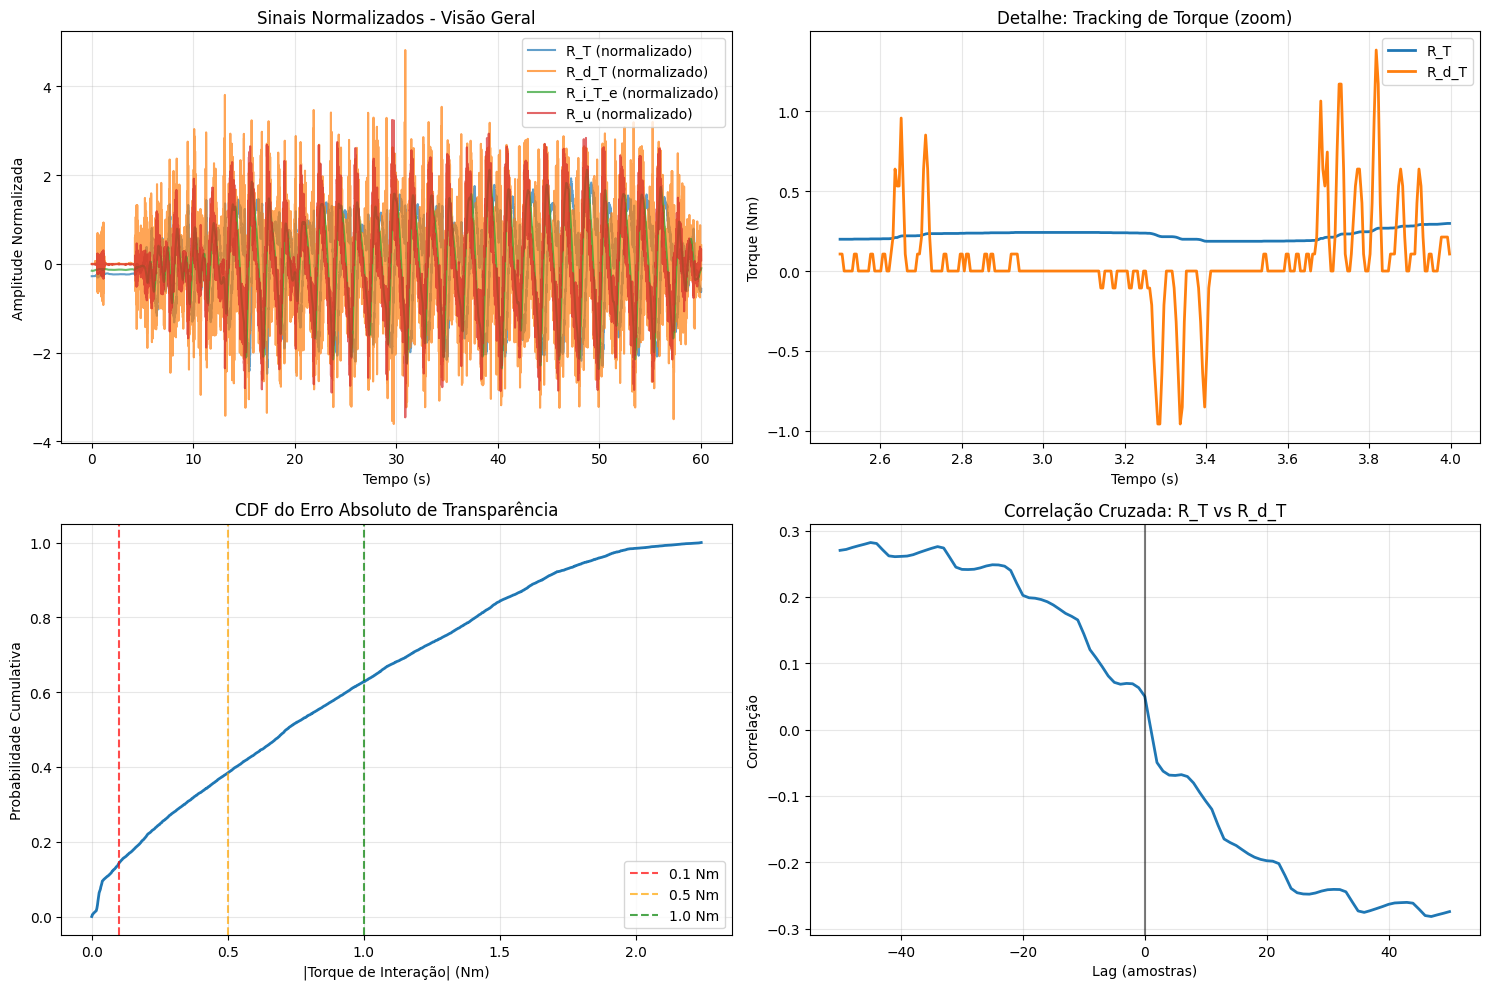

In [32]:
# Análise da performance do controle de transparência
print("\n=== ANÁLISE DA PERFORMANCE DE TRANSPARÊNCIA ===")

if all(col in markov_t6.columns for col in ['R_i_T_e', 'R_T', 'R_d_T']):
    # 1. Transparência ideal: τ_i ≈ 0
    transparency_metric = np.abs(markov_t6['R_i_T_e']).mean()
    transparency_std = markov_t6['R_i_T_e'].std()

    print(f"Torque de interação médio (ideal ≈ 0): {markov_t6['R_i_T_e'].mean():.4f} Nm")
    print(f"Valor absoluto médio do torque de interação: {transparency_metric:.4f} Nm")
    print(f"Desvio padrão do torque de interação: {transparency_std:.4f} Nm")

    # 2. Porcentagem do tempo dentro de tolerância
    tolerance_0_1 = np.abs(markov_t6['R_i_T_e']) <= 0.1
    tolerance_0_5 = np.abs(markov_t6['R_i_T_e']) <= 0.5
    tolerance_1_0 = np.abs(markov_t6['R_i_T_e']) <= 1.0

    print(f"\nTempo dentro de tolerância:")
    print(f"±0.1 Nm: {tolerance_0_1.mean()*100:.2f}%")
    print(f"±0.5 Nm: {tolerance_0_5.mean()*100:.2f}%")
    print(f"±1.0 Nm: {tolerance_1_0.mean()*100:.2f}%")

    # 3. Análise de tracking do torque
    tracking_error = markov_t6['R_d_T'] - markov_t6['R_T']
    tracking_rmse = np.sqrt((tracking_error**2).mean())
    tracking_mae = np.abs(tracking_error).mean()

    print(f"\nPerformance do tracking de torque:")
    print(f"RMSE do tracking: {tracking_rmse:.4f} Nm")
    print(f"MAE do tracking: {tracking_mae:.4f} Nm")

    # 4. Relação sinal-ruído (considerando o torque desejado como sinal)
    signal_power = (markov_t6['R_d_T']**2).mean()
    noise_power = (tracking_error**2).mean()
    snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')

    print(f"SNR do controle: {snr:.2f} dB")

# Gráfico final de resumo
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Resumo temporal completo
if all(col in markov_t6.columns for col in ['R_T', 'R_d_T', 'R_i_T_e', 'R_u']):
    # Normalizar para plotagem conjunta
    R_T_norm = (markov_t6['R_T'] - markov_t6['R_T'].mean()) / markov_t6['R_T'].std()
    R_d_T_norm = (markov_t6['R_d_T'] - markov_t6['R_d_T'].mean()) / markov_t6['R_d_T'].std()
    R_i_T_e_norm = (markov_t6['R_i_T_e'] - markov_t6['R_i_T_e'].mean()) / markov_t6['R_i_T_e'].std()
    R_u_norm = (markov_t6['R_u'] - markov_t6['R_u'].mean()) / markov_t6['R_u'].std()

    axes[0,0].plot(markov_t6['t'], R_T_norm, label='R_T (normalizado)', alpha=0.7)
    axes[0,0].plot(markov_t6['t'], R_d_T_norm, label='R_d_T (normalizado)', alpha=0.7)
    axes[0,0].plot(markov_t6['t'], R_i_T_e_norm, label='R_i_T_e (normalizado)', alpha=0.7)
    axes[0,0].plot(markov_t6['t'], R_u_norm, label='R_u (normalizado)', alpha=0.7)
    axes[0,0].set_title('Sinais Normalizados - Visão Geral')
    axes[0,0].set_xlabel('Tempo (s)')
    axes[0,0].set_ylabel('Amplitude Normalizada')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

# Zoom em uma região específica para análise detalhada
if len(markov_t6) > 1000:
    zoom_start = 500
    zoom_end = 800

    axes[0,1].plot(markov_t6['t'].iloc[zoom_start:zoom_end],
                   markov_t6['R_T'].iloc[zoom_start:zoom_end],
                   label='R_T', linewidth=2)
    axes[0,1].plot(markov_t6['t'].iloc[zoom_start:zoom_end],
                   markov_t6['R_d_T'].iloc[zoom_start:zoom_end],
                   label='R_d_T', linewidth=2)
    axes[0,1].set_title('Detalhe: Tracking de Torque (zoom)')
    axes[0,1].set_xlabel('Tempo (s)')
    axes[0,1].set_ylabel('Torque (Nm)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

# Distribuição cumulativa do erro de transparência
if 'R_i_T_e' in markov_t6.columns:
    sorted_abs_error = np.sort(np.abs(markov_t6['R_i_T_e']))
    cdf = np.arange(1, len(sorted_abs_error)+1) / len(sorted_abs_error)

    axes[1,0].plot(sorted_abs_error, cdf, linewidth=2)
    axes[1,0].axvline(x=0.1, color='red', linestyle='--', alpha=0.7, label='0.1 Nm')
    axes[1,0].axvline(x=0.5, color='orange', linestyle='--', alpha=0.7, label='0.5 Nm')
    axes[1,0].axvline(x=1.0, color='green', linestyle='--', alpha=0.7, label='1.0 Nm')
    axes[1,0].set_title('CDF do Erro Absoluto de Transparência')
    axes[1,0].set_xlabel('|Torque de Interação| (Nm)')
    axes[1,0].set_ylabel('Probabilidade Cumulativa')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

# Correlação cruzada entre torque desejado e realizado
if all(col in markov_t6.columns for col in ['R_T', 'R_d_T']):
    max_lag = 50
    correlations = []
    lags = range(-max_lag, max_lag+1)

    for lag in lags:
        if lag < 0:
            corr = np.corrcoef(markov_t6['R_T'].iloc[-lag:],
                              markov_t6['R_d_T'].iloc[:lag])[0,1]
        elif lag > 0:
            corr = np.corrcoef(markov_t6['R_T'].iloc[:-lag],
                              markov_t6['R_d_T'].iloc[lag:])[0,1]
        else:
            corr = np.corrcoef(markov_t6['R_T'], markov_t6['R_d_T'])[0,1]
        correlations.append(corr)

    axes[1,1].plot(lags, correlations, linewidth=2)
    axes[1,1].axvline(x=0, color='black', linestyle='-', alpha=0.5)
    axes[1,1].set_title('Correlação Cruzada: R_T vs R_d_T')
    axes[1,1].set_xlabel('Lag (amostras)')
    axes[1,1].set_ylabel('Correlação')
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Markov 7

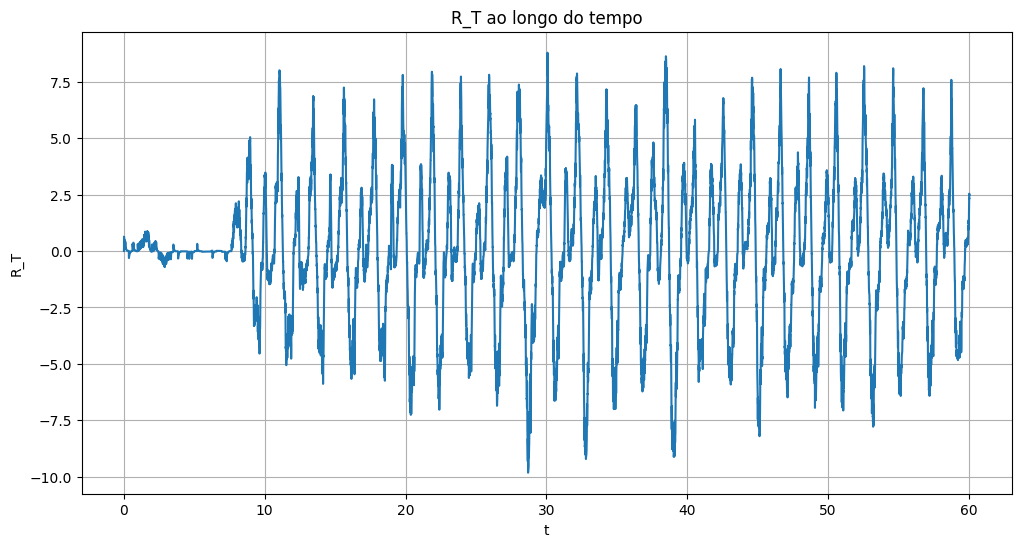

In [ ]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t7['t'].iloc[:], markov_t7['R_T'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

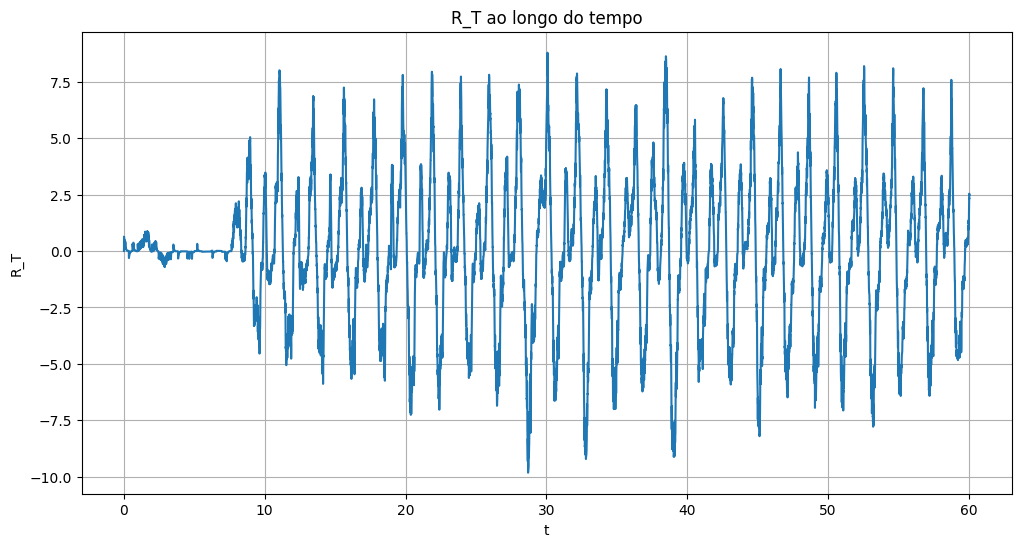

In [ ]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t7['t'].iloc[:], markov_t7['R_T'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()